We plot the top-k features selected by the sparse autoencoder for each category.

We make N axes to illustrate the top-k features for N categories.

In [1]:
import os
import sys
import pickle
import warnings

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from umap.umap_ import UMAP
from tqdm.notebook import tqdm

PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))
sys.path.append(str(PROJECT_ROOT / 'lib'))

from lib.models.standard_sae import AutoEncoder
from lib.models.gated_sae import GatedAutoEncoder
from lib.datasets.keat import get_keat_dataset
from lib.datasets.keat.utils import download_and_install_noto_font

Available fonts: ['Noto Mono', 'Noto Sans CJK KR']
Testing font installation...


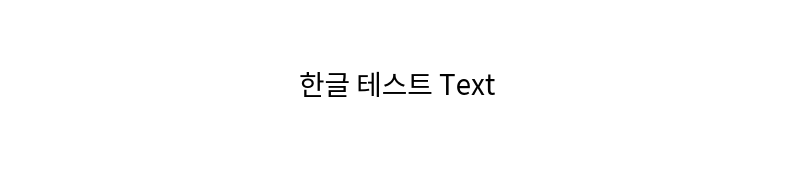

In [2]:
download_and_install_noto_font(test=True)

In [3]:
def get_sid2featuresum(sae, num_dict, activations):
    n_samples = len(activations)
    sid2featuresum = torch.zeros(n_samples, num_dict)
    for sid in tqdm(range(n_samples), "Counting features"):
        sample = activations[sid].to('cuda')
        _, features = sae(sample, output_features=True)
        sid2featuresum[sid] = torch.sum(features, dim=0).detach().cpu()
    return sid2featuresum

In [4]:
keat_dataset, _ = get_keat_dataset()

In [5]:
category2sids = {}
for sid, row in enumerate(keat_dataset['train']):
    for category in row['categories']:
        if category not in category2sids:
            category2sids[category] = []
        category2sids[category].append(sid)

In [6]:
# init settings
output_dir = PROJECT_ROOT / 'outputs'
device = torch.device('cuda')
sae_version = 'standard'
q = 2

In [7]:
# load activations
activation_dataset = 'keat-ko'
activations_path = output_dir / f'activations_exaone-8b_{activation_dataset}.pkl'
with open(activations_path, 'rb') as fpi:
    activations = pickle.load(fpi)
activations = activations[f'{activation_dataset}_residual_q{q}']

In [8]:
# load AE
sae_dataset = 'keat-ko'
sae_path = output_dir / f'sae-{sae_version}_exaone-8b_{sae_dataset}_q{q}'
if sae_version == 'standard':
    ae = AutoEncoder.from_pretrained(f'{sae_path}/model.pth')
elif sae_version == 'gated':
    ae = GatedAutoEncoder.from_pretrained(f'{sae_path}/model.pth')
ae.to(device)

AutoEncoder(
  (encoder): Linear(in_features=4096, out_features=100000, bias=True)
  (decoder): Linear(in_features=100000, out_features=4096, bias=False)
)

In [9]:
# get feature counts
num_dict = ae.dict_size
sid2featuresum = get_sid2featuresum(ae, num_dict, activations)

Counting features:   0%|          | 0/5034 [00:00<?, ?it/s]

In [10]:
# N x F 행렬에서 IDF 계산
n_samples = len(sid2featuresum)
df = (sid2featuresum > 0).float().sum(dim=0)  # 각 feature가 등장한 문서 수, F 차원 텐서
idf = torch.log(n_samples / (df + 1))  # smooth IDF, F 차원 텐서

# TF-IDF 계산
tfidf = sid2featuresum * idf.unsqueeze(0)

# L2 정규화
sid2featuresum_normalized = tfidf / torch.norm(tfidf, dim=1, keepdim=True)  # 각 sid별로 정규화
category2meanfeaturesum = {}
for category, sids in category2sids.items():
    category2meanfeaturesum[category] = sid2featuresum_normalized[sids].mean(dim=0)  # 카테고리별로 sid를 모아서 평균 때림

In [11]:
# 카테고리별 특징적인 feature top-k 추출
top_k = 100
all_topfids = []
category2topfids = {}
for category, meanfeaturesum in category2meanfeaturesum.items():
    _, topfids = torch.topk(meanfeaturesum, k=top_k, dim=-1)
    topfids = topfids.tolist()
    category2topfids[category] = topfids
    all_topfids.extend(topfids)
all_topfids = list(set(all_topfids))
print(len(all_topfids))

164


In [12]:
# apply umap to the top-k features for visualization

features = ae.decoder.weight.detach().T.cpu()
print(f"total features: {features.shape}" )

selected_features = features[all_topfids]
print(f"selected features: {selected_features.shape}" )

# (100000, 4096) -> (100000, 2))
warnings.filterwarnings('ignore')
umap = UMAP(n_components=2, random_state=42)
fid2xy = umap.fit_transform(selected_features.numpy())
print(f"fid2xy: {fid2xy.shape}")

total features: torch.Size([100000, 4096])
selected features: torch.Size([164, 4096])
fid2xy: (164, 2)


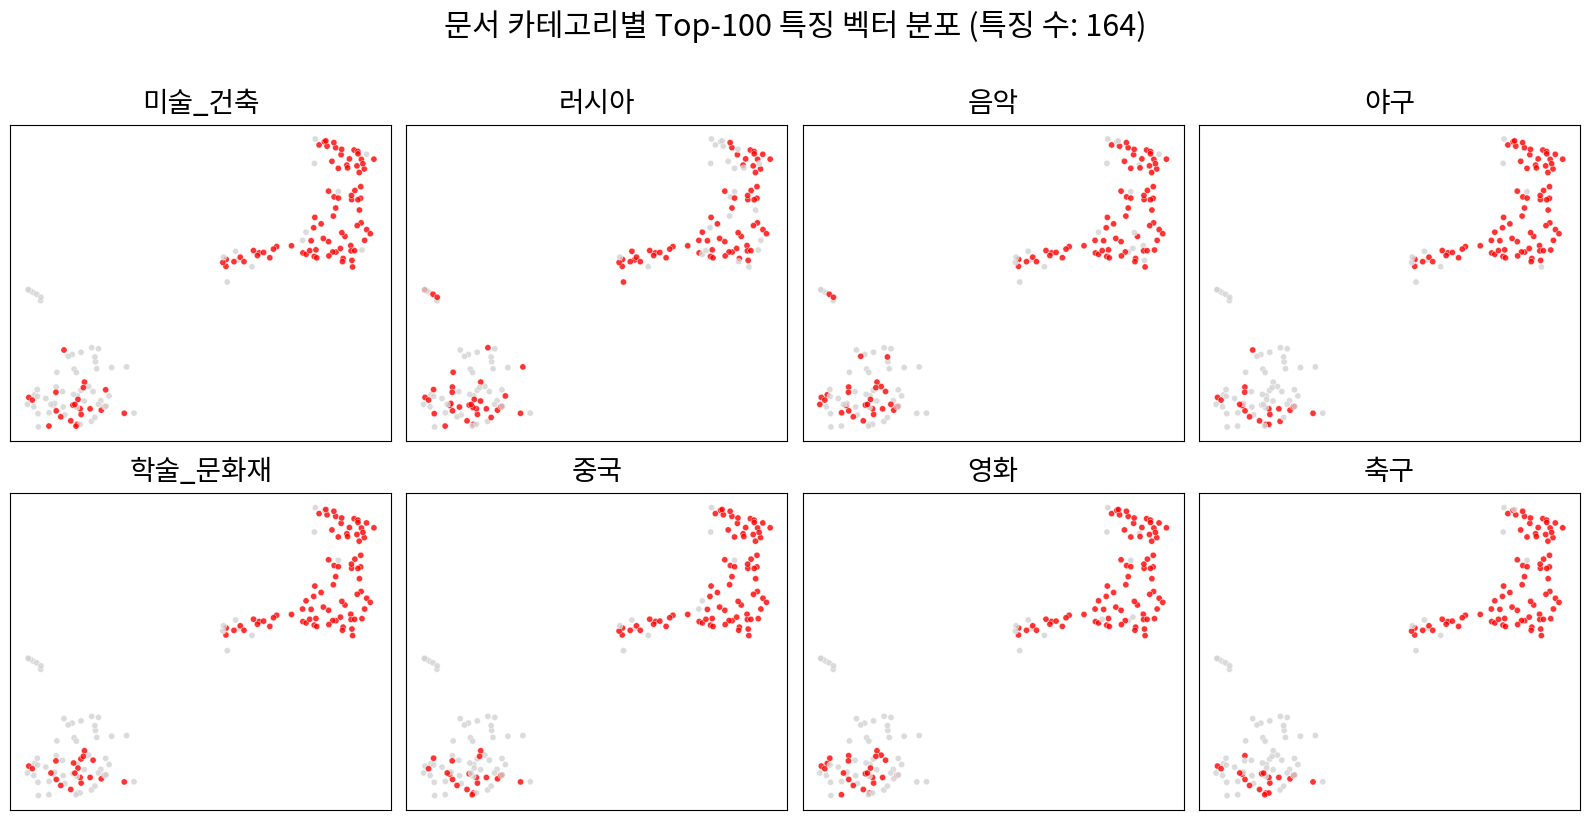

In [13]:
# 폰트 설정
plt.rcParams['font.family'] = 'Noto Sans CJK KR'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 그래프 설정
n_columns = 4
n_rows = 2
fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, 8))
axes = axes.flatten()

# 전체 제목 추가
fig.suptitle(
    f"문서 카테고리별 Top-{top_k} 특징 벡터 분포 (특징 수: {len(all_topfids)})",
    fontsize=22,
    y=1.02,
)

# 시각화 대상
selected_categories = [
    "미술_건축",
    "러시아",
    "음악",
    "야구",
    "학술_문화재",
    "중국",
    "영화",
    "축구",
]

for aid, ax in enumerate(axes):
    if aid >= len(selected_categories):
        break

    category = selected_categories[aid]
    topfids = category2topfids[category]

    colors = []
    for fid in all_topfids:
        if fid in topfids:
            colors.append('red')
        else:
            colors.append('lightgray')

    # 제목 스타일 개선
    ax.set_title(category, pad=10, fontsize=20)

    # 산점도 스타일 개선
    sns.scatterplot(
        x=fid2xy[:, 0],
        y=fid2xy[:, 1],
        hue=colors,
        alpha=0.8,  # 투명도 약간 증가
        ax=ax,
        legend=False,
        palette=['red', 'lightgray'],
        hue_order=['red', 'lightgray'],
        s=20,
    )  # 점 크기 약간 증가

    # 테두리 추가
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.set_xticks([])
    ax.set_yticks([])

# save figure
asset_dir = PROJECT_ROOT / 'assets'
plt.tight_layout()
plt.savefig(asset_dir / f'{activation_dataset}_sae-{sae_version}_q{q}_top-{top_k}_umap.png', dpi=300, bbox_inches='tight')
plt.show()

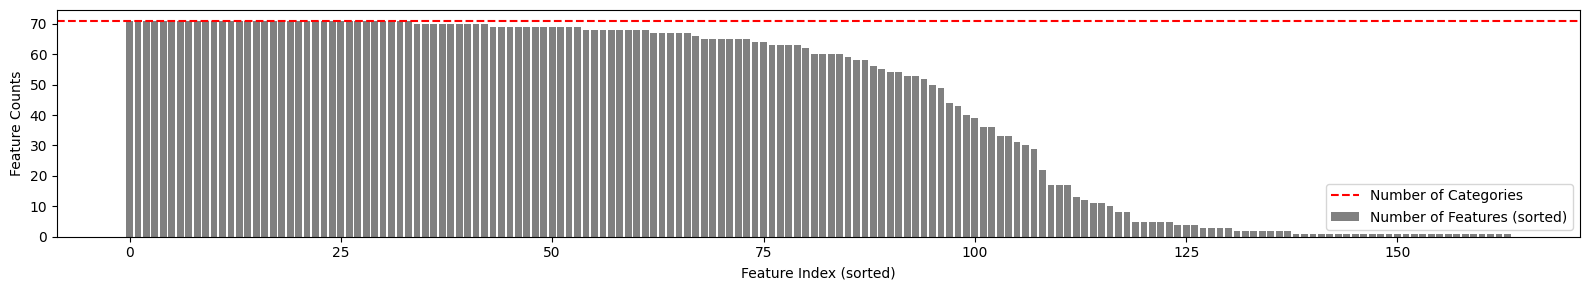

In [14]:
# hist plot of the feature activated for category
sns.reset_defaults()

findex2count = np.zeros(len(all_topfids))
fid2findex = {fid: findex for findex, fid in enumerate(all_topfids)}
for category, topfids in category2topfids.items():
    for fid in topfids:
        findex2count[fid2findex[fid]] += 1
sorted_counts = sorted(findex2count, reverse=True)

plt.figure(figsize=(16, 3))
plt.bar(list(range(len(sorted_counts))), sorted_counts, color='gray')
plt.axhline(y=len(category2topfids), color='red', linestyle="--")
plt.legend(["Number of Categories", "Number of Features (sorted)"])
plt.xlabel("Feature Index (sorted)")
plt.ylabel("Feature Counts")

# save figure
plt.tight_layout()
plt.savefig(asset_dir / f'{activation_dataset}_sae-{sae_version}_q{q}_top-{top_k}_feature_counts.png', dpi=300, bbox_inches='tight')
plt.show()